# DBSCAN 실습
### 이번 실습 시간에는 DBSCAN 기법을 이용한 실습을 진행할 예정


## 1.1 scikit learn package의 datasets함수를 통해 3가지 형태의 데이터셋 구성
- 3개의 떨어져 있는 cluster: make_blobs
- 2 Moon dataset (비선형 구조): make_moons
- Circles (동심원): make_circles


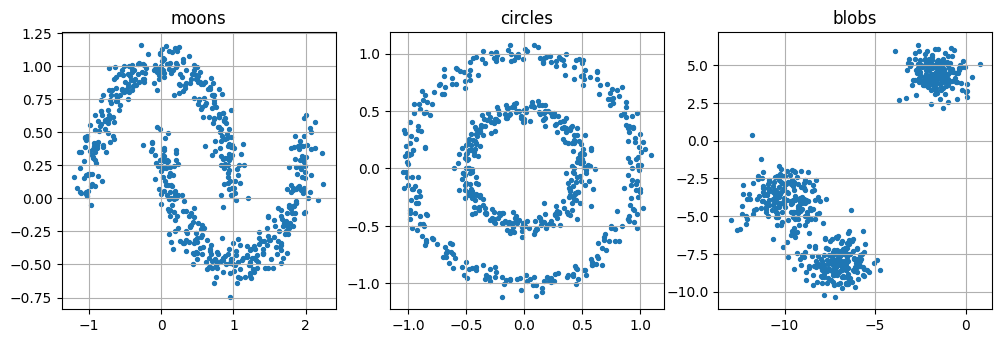

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles, make_blobs

X_moons, y_moons   = make_moons(n_samples=600, noise=0.09, random_state=1)
X_circles, y_circles = make_circles(n_samples=600, factor=0.5, noise=0.05, random_state=1)
X_blobs, y_blobs   = make_blobs(n_samples=600, centers=3, cluster_std=[0.8,1.1,0.9], random_state=1)

datasets = {
    "moons": X_moons,
    "circles": X_circles,
    "blobs": X_blobs,
}

# 시각화
fig, axes = plt.subplots(1,3, figsize=(12,3.6))
for ax, (name, X) in zip(axes, datasets.items()):
    ax.scatter(X[:,0], X[:,1], s=8)
    ax.set_title(name)
    ax.grid(True)
plt.show()

## 1.2 DBSCAN class 구현
- eps: DBSCAN 모델의 반경
- min_samples: core point로 인정하기 위한 최소 이웃 개수
- labels: 각 데이터의 클러스터 라벨
- core_samples_mask_: 각 데이터가 core point인지 여부

In [ ]:
import numpy as np

class DBSCAN:
    def __init__(self, eps=0.3, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.labels_ = None
        self.core_samples_mask_ = None

    def _pairwise_dist(self, x):
      # 입력 값 x는 (nxd)차원
      # 출력 값 D는 (nxn)차원 => D[i,j]는 i번째와 j번째 점 사이의 거리
      x = np.asarray(x, dtype=float)
      x_square = np.sum(x**2, axis=1, keepdims=True)
      D = np.sqrt(np.maximum(x_square + x_square.T - 2*(x@x.T), 0)) # numerical issue로 인해 거리의 제곱이 음의 값이 나오는 것을 방지

      return D

    def fit(self, x):
      x = np.asarray(x, dtype=float)
      n = x.shape[0]
      self.labels_ = -np.ones(n, dtype=int) # 초기값을 -1로 설정하여 모든 점을 noise로 취급하여 시작

      D = self._pairwise_dist(x)

      neighbors = [np.where(D[i] <= self.eps)[0] for i in range(n)] # 각 점의 epsilon 이웃 집합 구하기

      self.core_samples_mask_ = np.array([
          len(neighbors[i]) >= self.min_samples for i in range(n)
      ]) # neighbor의 개수가 min_samples보다 많으면 core point로 취급

      cid = 0 # 클러스터 이름 초기화
      visited = np.zeros(n, dtype=bool) # 방문 여부 기록

      for i in range(n):
        if visited[i]:
          continue
        visited[i] = True

        if not self.core_samples_mask_[i]:
          continue

        self.labels_[i] = cid
        queue = [i]
        while queue:
          p = queue.pop(0)
          for q in neighbors[p]:
            # 아직 방문하지 않은 점은 방문 처리
            if not visited[q] == True:
              visited[q] = True
              if self.core_samples_mask_[q]:
                queue.append(q) # core point면 queue에 추가하여 계속 확장

            if self.labels_[q] == -1:
              self.labels_[q] = cid # label을 지금의 클러스터 이름으로 변경
        cid += 1 # 클러스터 다음 이름 생성

    def fit_predict(self, x):
     self.fit(x)
     return self.labels_


## 1.3 Epsilon neighbors를 찾기 위한 거리 계산
- n개의 데이터에 대해 서로간의 거리를 재야 함
- 계산상의 편의를 위해 먼저 $\|x\|^2$을 계산해 놓고 사용하는 방식을 이용

In [ ]:
def _pairwise_dist(self, x):
  # 입력 값 x는 (nxd)차원
  # 출력 값 D는 (nxn)차원 => D[i,j]는 i번째와 j번째 점 사이의 거리
  x = np.asarray(x, dtype=float)
  x_square = np.sum(x**2, axis=1, keepdims=True)
  D = np.sqrt(np.maximum(x_square + x_square.T - 2*(x@x.T), 0)) # numerical issue로 인해 거리의 제곱이 음의 값이 나오는 것을 방지

  return D

## 1.4 거리 함수를 이용하여 clustering
- 위에서 정의한 거리 함수를 이용하여 cluster를 진행하는 함수 구현
- 먼저 거리를 기반으로 각 점의 $\epsilon$-이웃을 찾고 core point 여부를 확인
- 이후 DBSCAN의 알고리즘에 따라 clustering 진행

In [ ]:
def fit(self, x):
  x = np.asarray(x, dtype=float)
  n = x.shape[0]
  self.labels_ = -np.ones(n, dtype=int) # 초기값을 -1로 설정하여 모든 점을 noise로 취급하여 시작

  D = self._pairwise_dist(x)

  neighbors = [np.where(D[i] <= self.eps)[0] for i in range(n)] # 각 점의 epsilon 이웃 집합 구하기

  self.core_samples_mask_ = np.array([
      len(neighbors[i]) >= self.min_samples for i in range(n)
  ]) # neighbor의 개수가 min_samples보다 많으면 core point로 취급

  cid = 0 # 클러스터 이름 초기화
  visited = np.zeros(n, dtype=bool) # 방문 여부 기록

  for i in range(n):
    if visited[i]:
      continue
    visited[i] = True

    if not self.core_samples_mask_[i]:
      continue

    self.labels_[i] = cid ## i번째 데이터에 현재 cluster 이름을 label로 넣어줌
    queue = [i] ## core point들을 모아 놓는 queue
    while queue:
      p = queue.pop(0)
      for q in neighbors[p]:
        # 아직 방문하지 않은 점은 방문 처리
        if not visited[q] == True:
          visited[q] = True
          if self.core_samples_mask_[q]:
            queue.append(q) # core point면 queue에 추가하여 계속 확장

        if self.labels_[q] == -1:
          self.labels_[q] = cid # label을 지금의 클러스터 이름으로 변경
    cid += 1 # 클러스터 다음 이름 생성

## 1.5 k distance plot을 이용한 epsilon 선택
- 각 점으로부터 $k$th distance를 가지는 점을 찾기 위해 scikitlearn package의 NearestNeighbors class 이용
- $k$ distance plot을 이용해 적절한 epsilon을 선택

In [ ]:
from sklearn.neighbors import NearestNeighbors

def k_distance_plot(X, k=5):
    # kNN 거리 분포(오름차순) → knee 근처가 eps 후보
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    dists, _ = nbrs.kneighbors(X)
    kth = np.sort(dists[:, -1])
    plt.figure(figsize=(6,4))
    plt.plot(kth)
    plt.xlabel("Points sorted by distance")
    plt.ylabel(f"{k}-NN distance")
    plt.title(f"k-distance plot (k={k})")
    plt.grid(True)
    plt.show()

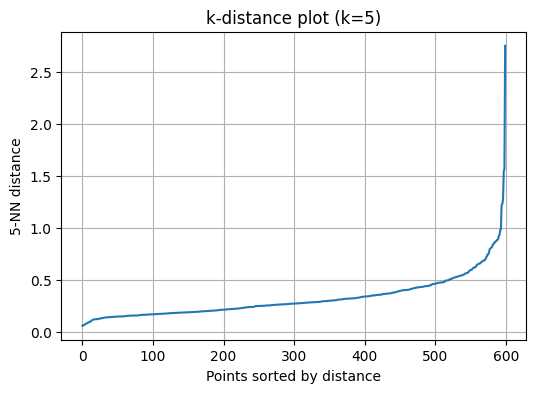

In [ ]:
X = datasets["blobs"]
k_distance_plot(X, k=5)

## 1.6 3개의 cluster data를 이용하여 clustering해보기

In [ ]:
def plot_clusters(X, labels, title="DBSCAN"):
    unique = np.unique(labels)
    plt.figure(figsize=(5,4))
    for u in unique:
        mask = (labels == u)
        if u == -1:
            plt.scatter(X[mask,0], X[mask,1], s=15, marker='x', label='noise (-1)')
        else:
            plt.scatter(X[mask,0], X[mask,1], s=15, label=f'cluster {u}')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

[blobs] clusters=2 noise=0 (eps=1.0, min_samples=5)


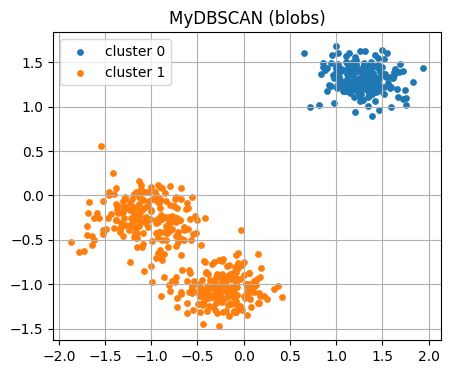

In [ ]:
from sklearn.preprocessing import StandardScaler

for name in ["blobs"]:
    X = datasets[name]
    Xs = StandardScaler().fit_transform(X)
    eps, ms = (1.0,5)
    labels = DBSCAN(eps=eps, min_samples=ms).fit_predict(Xs)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = int(np.sum(labels==-1))
    print(f"[{name}] clusters={n_clusters} noise={n_noise} (eps={eps}, min_samples={ms})")
    plot_clusters(Xs, labels, title=f"MyDBSCAN ({name})")

[blobs] clusters=3 noise=9 (eps=0.15, min_samples=3)


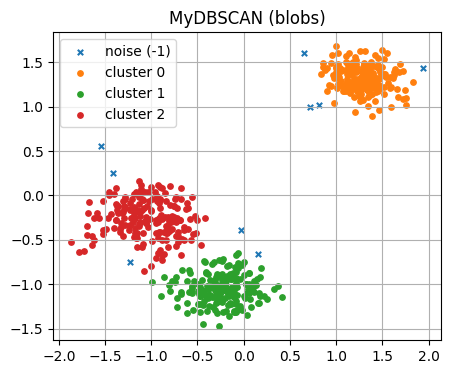

In [ ]:
for name in ["blobs"]:
    X = datasets[name]
    Xs = StandardScaler().fit_transform(X)
    eps, ms = (0.15,3)
    labels = DBSCAN(eps=eps, min_samples=ms).fit_predict(Xs)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = int(np.sum(labels==-1))
    print(f"[{name}] clusters={n_clusters} noise={n_noise} (eps={eps}, min_samples={ms})")
    plot_clusters(Xs, labels, title=f"MyDBSCAN ({name})")

## 1.7 Two moon dataset을 이용하여 clustering해보기

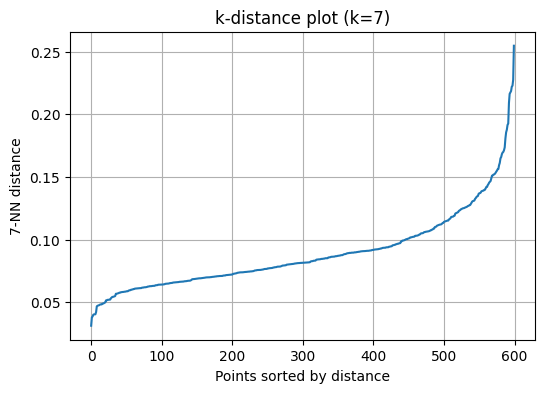

In [ ]:
X = datasets["moons"]
k_distance_plot(X, k=7)

[moons] clusters=15 noise=97 (eps=0.13, min_samples=7)


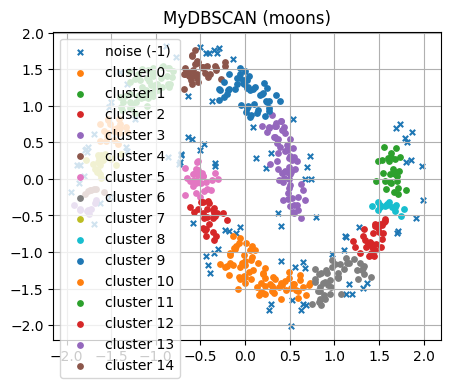

In [ ]:
for name in ["moons"]:
    X = datasets[name]
    Xs = StandardScaler().fit_transform(X)
    eps, ms = (0.13,7)
    labels = DBSCAN(eps=eps, min_samples=ms).fit_predict(Xs)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = int(np.sum(labels==-1))
    print(f"[{name}] clusters={n_clusters} noise={n_noise} (eps={eps}, min_samples={ms})")
    plot_clusters(Xs, labels, title=f"MyDBSCAN ({name})")

## 1.8 동심원 데이터를 이용하여 clustering해보기

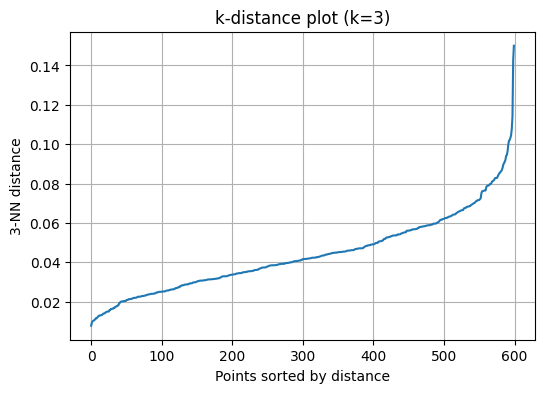

In [ ]:
X = datasets["circles"]
k_distance_plot(X, k=3)

[circles] clusters=2 noise=2 (eps=0.2, min_samples=3)


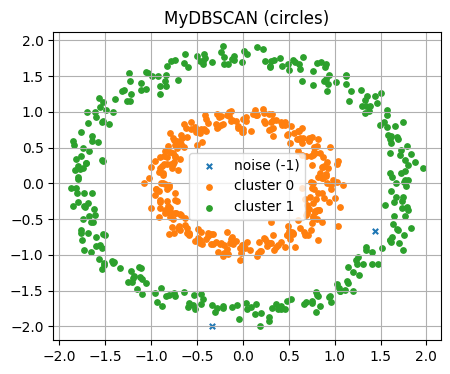

In [ ]:
for name in ["circles"]:
    X = datasets[name]
    Xs = StandardScaler().fit_transform(X)
    eps, ms = (0.2,3)
    labels = DBSCAN(eps=eps, min_samples=ms).fit_predict(Xs)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = int(np.sum(labels==-1))
    print(f"[{name}] clusters={n_clusters} noise={n_noise} (eps={eps}, min_samples={ms})")
    plot_clusters(Xs, labels, title=f"MyDBSCAN ({name})")

## 2.1 scikit learn package를 이용하여 DBSCAN과 k Means clustering 비교해보

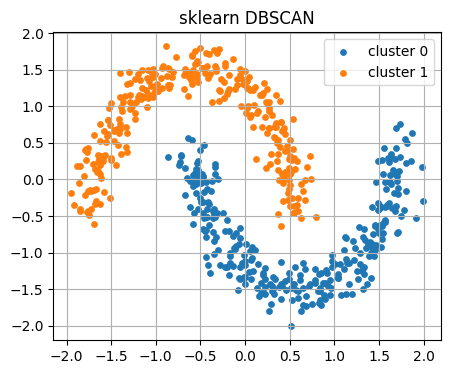

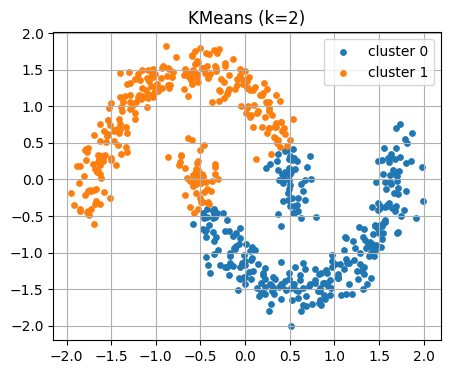

In [ ]:
from sklearn.cluster import DBSCAN as SkDBSCAN
from sklearn.cluster import KMeans

name = "moons"
X = datasets[name]
Xs = StandardScaler().fit_transform(X)

sk = SkDBSCAN(eps=0.25, min_samples=5).fit(Xs)
plot_clusters(Xs, sk.labels_, title="sklearn DBSCAN")

km = KMeans(n_clusters=2, n_init=10, random_state=7).fit(Xs)
plot_clusters(Xs, km.labels_, title="KMeans (k=2)")